### Import Library & Functions

> Dataset Name: FER2013 (Facial Expression Recognition 2013)

> Reference: International Conference on Machine Learning (ICML 2013) https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer

> Relevant Links: https://datasets.activeloop.ai/docs/ml/datasets/fer2013-dataset/

In [71]:
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
from tensorflow.keras.applications import EfficientNetB0

import pathlib
import json
%matplotlib inline

In [72]:
# 각 클래스에 대한 True Positive, False Positive, False Negative, True Negative 계산
def get_tp_fp_fn_tn(cm, class_idx):
    TP = cm[class_idx, class_idx]
    FP = cm[:, class_idx].sum() - TP
    FN = cm[class_idx, :].sum() - TP
    TN = cm.sum() - (TP + FP + FN)
    return TP, FP, FN, TN

# Precision, Recall, F1-Score 계산
def calculate_metrics(TP, FP, FN):
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

# 각 데이터셋의 클래스별 이미지 분포도 시각화
def plot_class_distribution(dataset, title):
    class_names = dataset.class_names
    class_counts = [0] * len(class_names)

    for _, labels in dataset:
        for label in labels.numpy():
            class_counts[np.argmax(label)] += 1

    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

In [2]:
os.getcwd()

'c:\\Users\\Inkyu Yang\\20242402\\emotion_analysis'

### Train Set Split

- **image_dataset_from_directory** 함수가 Train/Validation Split 도중 클래스 불균형을 심각하게 일으켜 직접 분리

In [ ]:
src_dir = './img/train'
train_new_dir = './img/training'
val_dir = './img/val'

os.makedirs(train_new_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
classes = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]

for cls in classes:
    src_cls_dir = os.path.join(src_dir, cls)
    train_cls_dir = os.path.join(train_new_dir, cls)
    val_cls_dir = os.path.join(val_dir, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    os.makedirs(val_cls_dir, exist_ok=True)
    img_files = os.listdir(src_cls_dir)
    img_files = np.array(img_files)
    train_files, val_files = train_test_split(
        img_files, test_size=0.2, random_state=42
    )
    for f in train_files:
        shutil.copy2(os.path.join(src_cls_dir, f), os.path.join(train_cls_dir, f))
    for f in val_files:
        shutil.copy2(os.path.join(src_cls_dir, f), os.path.join(val_cls_dir, f))

### Data Loading and Preprocessing (RGB)

In [3]:
# 경로 설정
data_dir = pathlib.Path('./img/img')
train_dir = data_dir / 'training'
#train_angry = train_dir / 'angry'
#train_disgusted = train_dir / 'disgusted'
#train_fearful = train_dir / 'fearful'
#train_happy = train_dir / 'happy'
#train_neutral = train_dir / 'neutral'
#train_sad = train_dir / 'sad'
#train_surprised = train_dir / 'surprised'

val_dir = data_dir / 'val'

test_dir = data_dir / 'test'
#test_angry = test_dir / 'angry'
#test_disgusted = test_dir / 'disgusted'
#test_fearful = test_dir / 'fearful'
#test_happy = test_dir / 'happy'
#test_neutral = test_dir / 'neutral'
#test_sad = test_dir / 'sad'
#test_surprised = test_dir / 'surprised'

In [4]:
list(train_dir.glob('*/*'))
print(np.array(list(train_dir.glob('*/*'))), '\n')
list(test_dir.glob('*/*'))
print(np.array(list(test_dir.glob('*/*'))))

[WindowsPath('img/img/training/angry/im0.png')
 WindowsPath('img/img/training/angry/im1.png')
 WindowsPath('img/img/training/angry/im10.png') ...
 WindowsPath('img/img/training/surprised/im997.png')
 WindowsPath('img/img/training/surprised/im998.png')
 WindowsPath('img/img/training/surprised/im999.png')] 

[WindowsPath('img/img/test/angry/im0.png')
 WindowsPath('img/img/test/angry/im1.png')
 WindowsPath('img/img/test/angry/im10.png') ...
 WindowsPath('img/img/test/surprised/im97.png')
 WindowsPath('img/img/test/surprised/im98.png')
 WindowsPath('img/img/test/surprised/im99.png')]


In [5]:
train_image_paths = list(train_dir.glob('*/*'))
test_image_paths = list(test_dir.glob('*/*'))

In [6]:
print("Train set length: ", len(train_image_paths))
print("Test set length: ", len(test_image_paths))
# Train 75 : Test 25 ratio

Train set length:  22965
Test set length:  7178


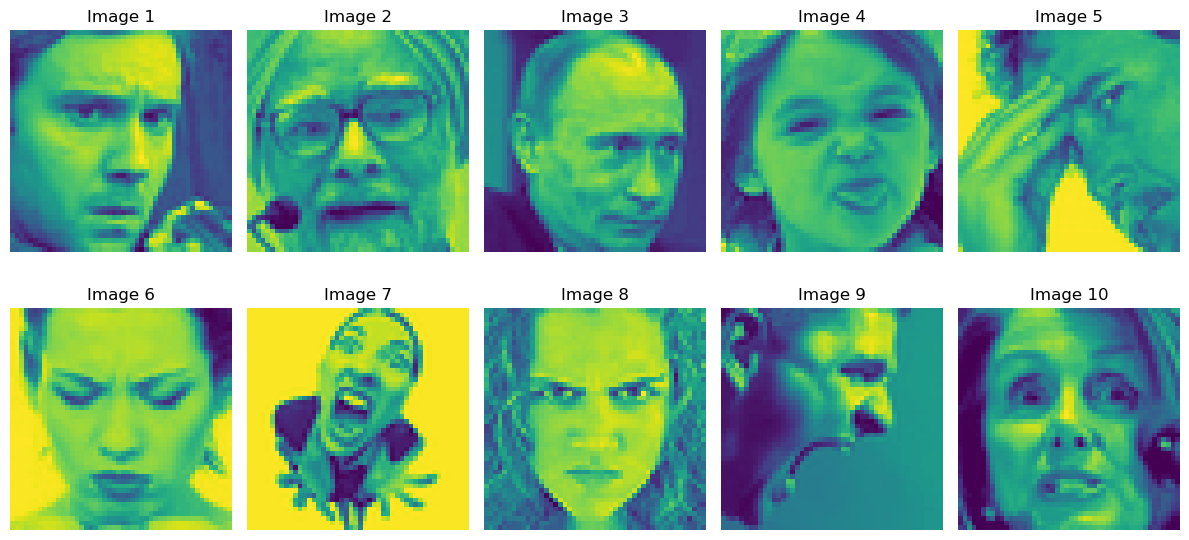

In [7]:
# For test
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

for i in range(0, 10):
    img = PIL.Image.open(train_image_paths[i])
    axes[i].imshow(img)
    axes[i].axis('off')  # 축 숨기기
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [8]:
# Pixel size: 48x48
batch_size = 64
img_size = (64, 64)

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  #validation_split=0.2,
  labels='inferred',
  label_mode='categorical',
  #subset="training",
  seed=42,
  image_size=(img_size[0], img_size[1]),
  batch_size=batch_size,
  shuffle = True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    #validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    #subset="validation",
    seed=42,
    image_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    shuffle=False # 검증 데이터는 일반적으로 셔플링하지 않음
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    shuffle=False, # 테스트 데이터는 일반적으로 셔플링하지 않음
    seed=42      # 재현성을 위해 seed 설정 (데이터 순서에 영향 없음)
)

Found 22965 files belonging to 7 classes.
Found 5744 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [9]:
print(train_ds.class_names)
print(val_ds.class_names)
print(test_ds.class_names)

class_names = train_ds.class_names

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


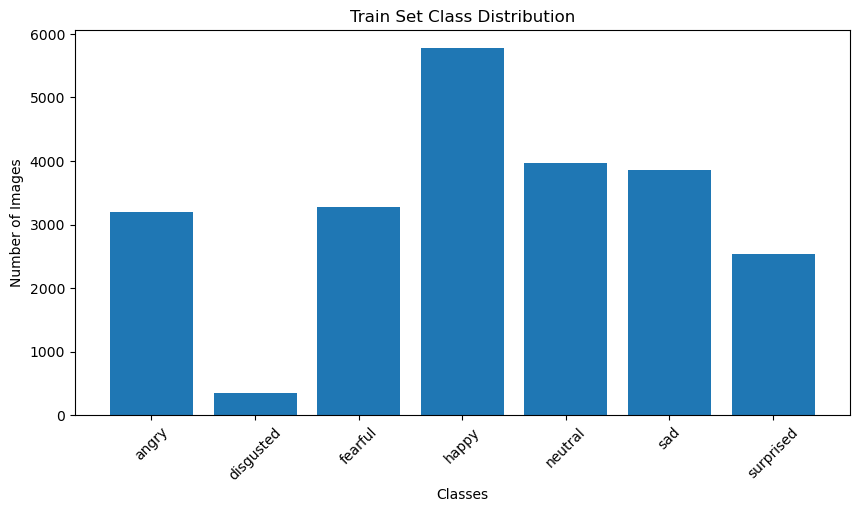

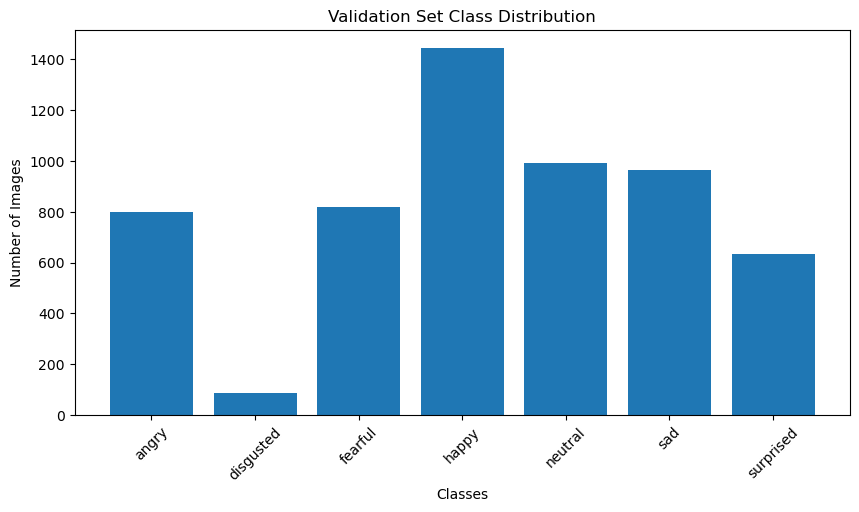

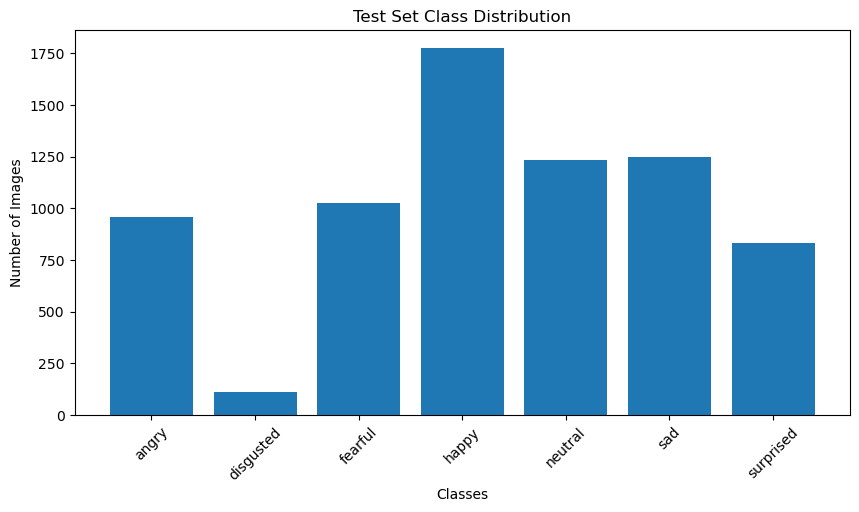

In [ ]:
plot_class_distribution(train_ds, 'Train Set Class Distribution')
plot_class_distribution(val_ds, 'Validation Set Class Distribution')
plot_class_distribution(test_ds, 'Test Set Class Distribution')

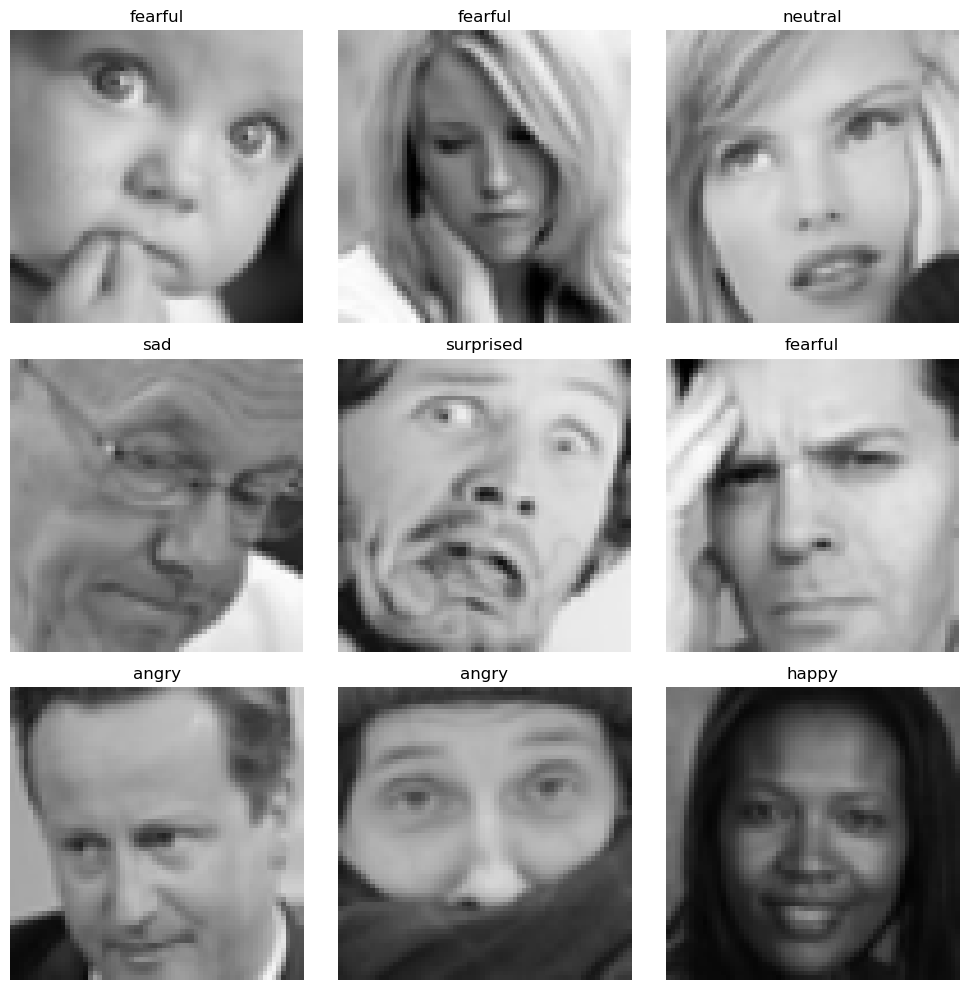

In [11]:
# 데이터셋 이미지 확인
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i]).numpy()])
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [12]:
# 이미지 구조
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)  # batch, height, width, RGB channel
  print(labels_batch.shape)    # batch
  break

for image_batch, labels_batch in val_ds:
  print(image_batch.shape)  # batch, height, width, RGB channel
  print(labels_batch.shape)    # batch
  break

for image_batch, labels_batch in test_ds:
  print(image_batch.shape)  # batch, height, width, RGB channel
  print(labels_batch.shape)    # batch
  break

(64, 64, 64, 3)
(64, 7)
(64, 64, 64, 3)
(64, 7)
(64, 64, 64, 3)
(64, 7)


In [13]:
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(val_ds))
print(tf.data.experimental.cardinality(test_ds))

tf.Tensor(359, shape=(), dtype=int64)
tf.Tensor(90, shape=(), dtype=int64)
tf.Tensor(113, shape=(), dtype=int64)


In [14]:
# 데이터 로딩 병목 완화
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

In [15]:
# RGB Channel Range 1 to 255. Therefore, it needs to be rescaled.
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))  # lambda Function for Normalization
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in [0,1].
print(np.min(first_image), np.max(first_image))

# To adjust pixel values to [-1, 1]
# tf.keras.layers.Rescaling(1./127.5, offset=-1)

# normalized_train_ds = train_ds.map(lambda x, y: (tf.image.convert_image_dtype(x, dtype=tf.float32), y))
# normalized_val_ds = val_ds.map(lambda x, y: (tf.image.convert_image_dtype(x, dtype=tf.float32), y))
# normalized_test_ds = test_ds.map(lambda x, y: (tf.image.convert_image_dtype(x, dtype=tf.float32), y))


0.0004901961 0.97450984


### Convolutional Neural Network (RGB)

#### 2D CNN Model (RGB)

> 4 Convolutional Layers + 2 FC Layers

> Learning Time: 84 Mins

In [ ]:
# 데이터 증강 레이어
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),              # 약 3도 (0.05*360)
    layers.RandomTranslation(0.05, 0.05),     # 약 3픽셀 이동 (0.05*64)
    layers.RandomZoom(0.1),                   # 10% 확대/축소
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
])

# CNN 모델 (커널 사이즈 조절함으로써 이미지의 특징을 더 잘 추출할 수 있도록 함)
cnn_model = tf.keras.Sequential([
    keras.Input(shape=(img_size[0], img_size[1], 3)),   # Input Layer
    data_augmentation,   # Data Augmentation Layer, 데이터 증강
    layers.Rescaling(1./255),   # Rescaling Layer, 정규화
    
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),    # 1st Convolutional Layer, 32 Filters
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),  # Maxpooling Layer, 다운샘플링, 과적합 방지
    layers.Dropout(0.2),

    layers.Conv2D(64, (5, 5), padding='same', activation='relu'),    # 2nd Convolutional Layer, 32 Filters
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),  # Maxpooling Layer, 다운샘플링, 과적합 방지
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (5, 5), padding='same', activation='relu'),    # 3rd Convolutional Layer, 64 Filters
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),  # Maxpooling Layer, 다운샘플링, 과적합 방지
    layers.Dropout(0.2),
    
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),    # 4th Convolutional Layer, 128 Filters
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),  # Maxpooling Layer, 다운샘플링, 과적합 방지
    layers.Dropout(0.2),
    
    layers.Flatten(), # Flatten Layer, 1차원 벡터로 변환
    layers.Dense(512, activation='relu'),   # 첫 번째 FC Layer (뉴런 수 감소)
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(256, activation='relu'),   # FC Layer
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax') # Output Layer
])

In [77]:
# 최적화 알고리즘, 손실 함수 설정, 평가 지표
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_9 (Sequential)       │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_8 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,788,039 (10.64 MB)

 Trainable params: 2,785,543 (10.63 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [78]:
# 모델 학습
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
history = cnn_model.fit(train_ds, epochs=50, validation_data=val_ds, 
                        callbacks=[early_stopping, reduce_lr])

Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 108s 291ms/step - accuracy: 0.1779 - loss: 2.6396 - val_accuracy: 0.2013 - val_loss: 2.2903 - learning_rate: 1.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 95s 265ms/step - accuracy: 0.2135 - loss: 2.2456 - val_accuracy: 0.2911 - val_loss: 1.8366 - learning_rate: 1.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 90s 250ms/step - accuracy: 0.2413 - loss: 2.0690 - val_accuracy: 0.3294 - val_loss: 1.7395 - learning_rate: 1.0000e-04
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 91s 254ms/step - accuracy: 0.2664 - loss: 1.9893 - val_accuracy: 0.3511 - val_loss: 1.6867 - learning_rate: 1.0000e-04
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 98s 273ms/step - accuracy: 0.2859 - loss: 1.9182 - val_accuracy: 0.3703 - val_loss: 1.6338 - learning_rate: 1.0000e-04
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 98s 271ms/step - accuracy: 0.3157 - loss: 1.8415 - val_accuracy: 0.3787 - val_loss: 1.6121 - learning_rate: 1.0000e-04
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 97s 2

In [81]:
# CNN 모델 평가
test_loss, test_accuracy = cnn_model.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.5701 - loss: 1.1451
Test Loss: 1.0178780555725098
Test Accuracy: 0.6196712255477905


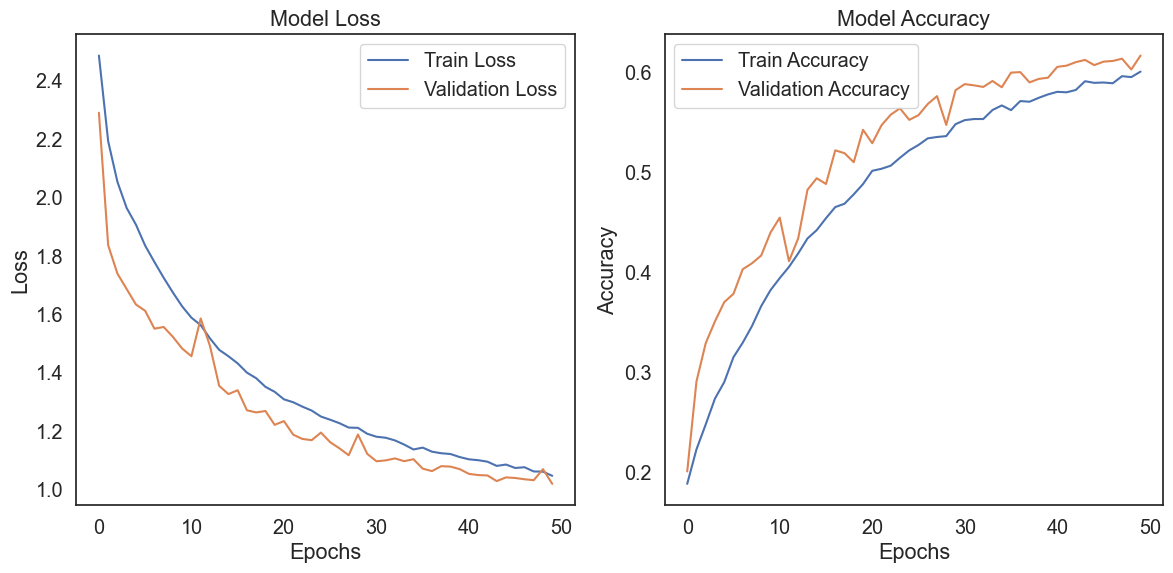

In [82]:
# 손실 함수 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [83]:
# 예측 및 confusion matrix 계산
y_pred = cnn_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_true = []
for _, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # 원-핫 → 정수 인덱스
y_true = np.array(y_true)

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step


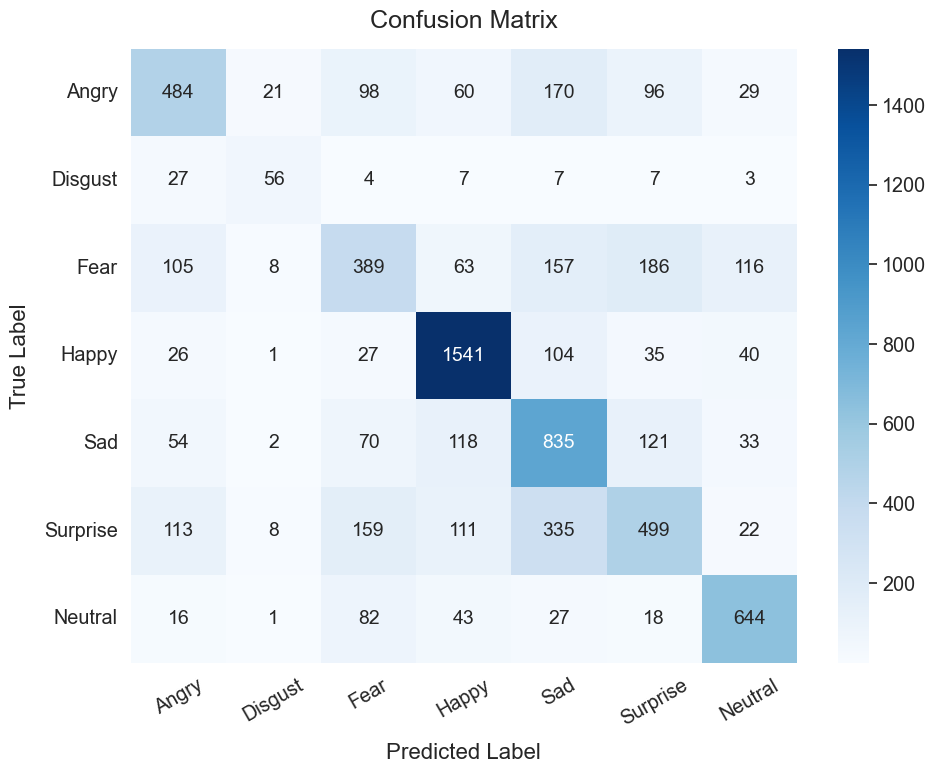

In [84]:
# Confusion matrix 계산
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.3)
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    cmap='Blues',
    cbar=True,
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 14}
)
ax.set_xlabel('Predicted Label', fontsize=16, labelpad=10)
ax.set_ylabel('True Label', fontsize=16, labelpad=10)
ax.set_title('Confusion Matrix', fontsize=18, pad=15)
plt.yticks(rotation=0)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [85]:
# 모든 클래스에 대해 TP, FP, FN, TN 및 Precision, Recall, F1-score 출력
for idx, name in enumerate(class_names):
    TP, FP, FN, TN = get_tp_fp_fn_tn(cm, idx)
    precision, recall, f1_score = calculate_metrics(TP, FP, FN)
    print(f"[{name}]")
    print(f"  TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
    print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}\n")

[Angry]
  TP: 484, FP: 341, FN: 474, TN: 5879
  Precision: 0.5867, Recall: 0.5052, F1-Score: 0.5429

[Disgust]
  TP: 56, FP: 41, FN: 55, TN: 7026
  Precision: 0.5773, Recall: 0.5045, F1-Score: 0.5385

[Fear]
  TP: 389, FP: 440, FN: 635, TN: 5714
  Precision: 0.4692, Recall: 0.3799, F1-Score: 0.4199

[Happy]
  TP: 1541, FP: 402, FN: 233, TN: 5002
  Precision: 0.7931, Recall: 0.8687, F1-Score: 0.8292

[Sad]
  TP: 835, FP: 800, FN: 398, TN: 5145
  Precision: 0.5107, Recall: 0.6772, F1-Score: 0.5823

[Surprise]
  TP: 499, FP: 463, FN: 748, TN: 5468
  Precision: 0.5187, Recall: 0.4002, F1-Score: 0.4518

[Neutral]
  TP: 644, FP: 243, FN: 187, TN: 6104
  Precision: 0.7260, Recall: 0.7750, F1-Score: 0.7497



In [87]:
# 모델 저장
#cnn_model.save('cnn_emotion_model_rgb.h5')

# History 저장
with open('emotion_cnn_rgb_history.json', 'w') as f:
    json.dump(history.history, f)

## Grayscale

#### Data Preprocessing and Loading (grayscale)

In [39]:
batch_size = 64
img_size = (64, 64)  # 이미지 크기 (너비, 높이)

train_ds_gray = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  color_mode='grayscale',
  #validation_split=0.2,
  labels='inferred',
  label_mode='categorical',
  #subset="training",
  seed=42,
  image_size=(img_size[0], img_size[1]),
  batch_size=batch_size,
  shuffle = True)

val_ds_gray = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    color_mode='grayscale',
    #validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    #subset="validation",
    seed=42,
    image_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    shuffle=False # 검증 데이터는 일반적으로 셔플링하지 않음
)

test_ds_gray = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    color_mode='grayscale',
    labels='inferred',
    label_mode='categorical',
    image_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    shuffle=False, # 테스트 데이터는 일반적으로 셔플링하지 않음
    seed=42      # 재현성을 위해 seed 설정 (데이터 순서에 영향 없음)
)

Found 22965 files belonging to 7 classes.
Found 5744 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


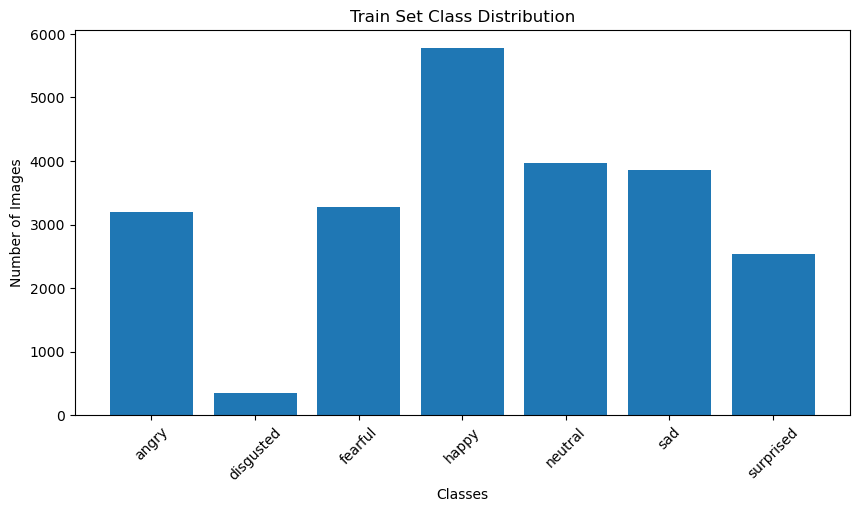

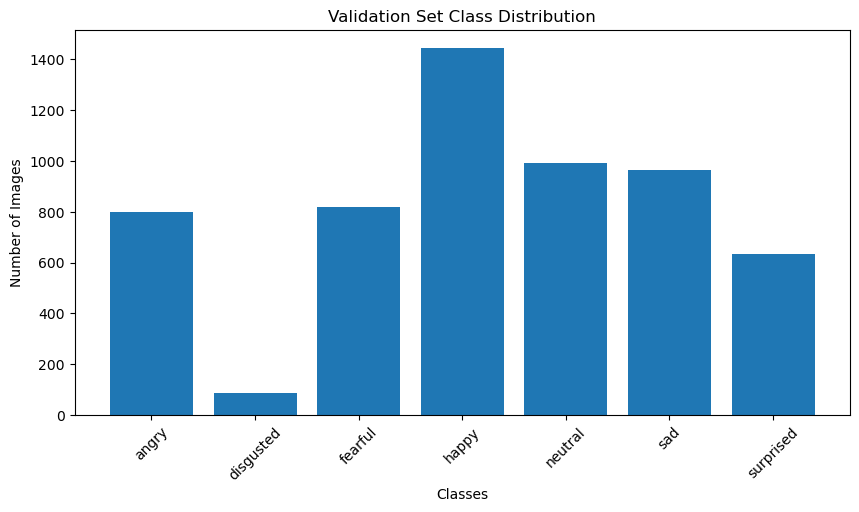

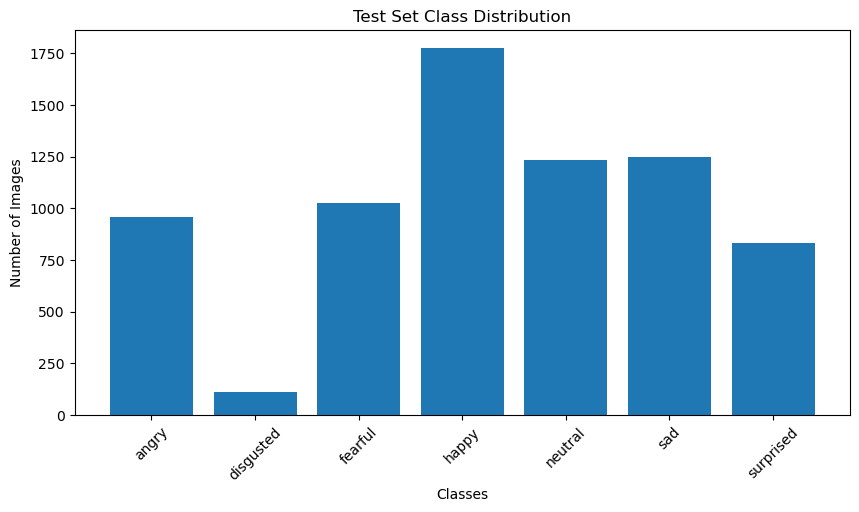

In [40]:
plot_class_distribution(train_ds_gray, 'Train Set Class Distribution')
plot_class_distribution(val_ds_gray, 'Validation Set Class Distribution')
plot_class_distribution(test_ds_gray, 'Test Set Class Distribution')

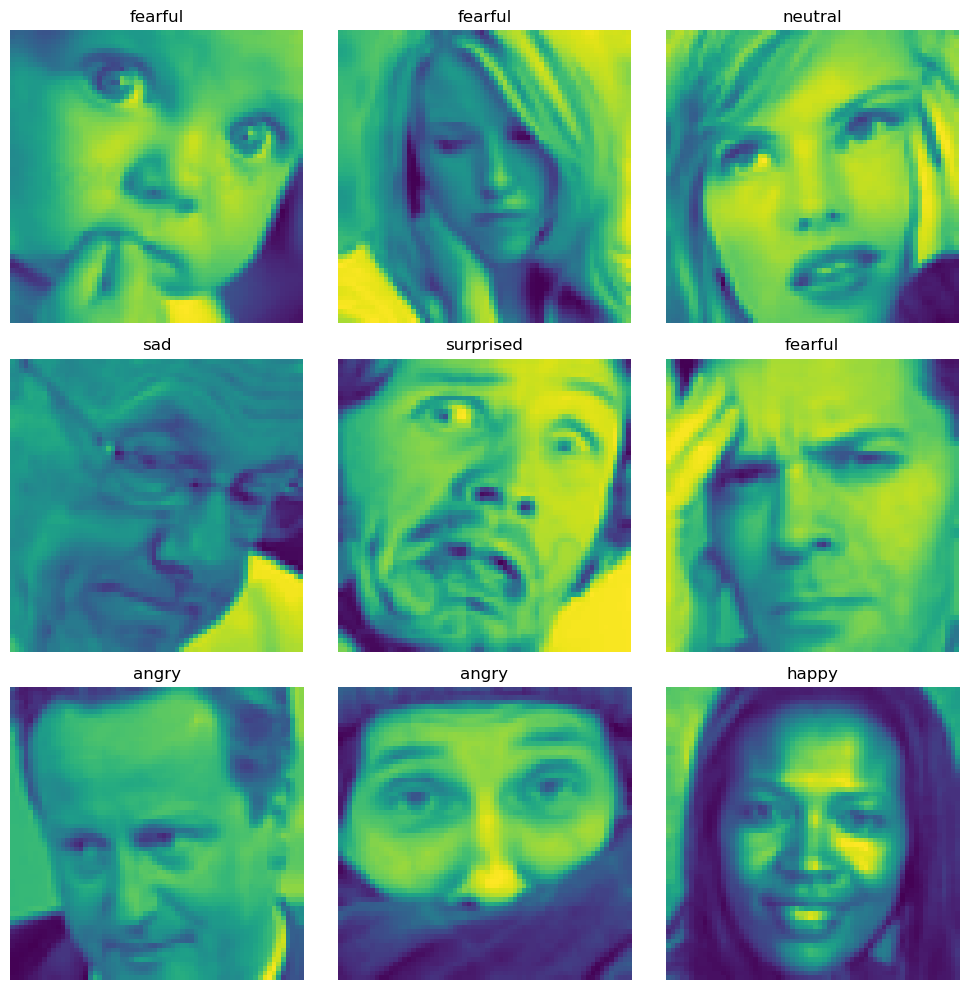

In [41]:
# 데이터셋 이미지 확인
plt.figure(figsize=(10, 10))
for images, labels in train_ds_gray.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[tf.argmax(labels[i]).numpy()])
    plt.axis("off")
    
plt.tight_layout()
plt.show()

In [42]:
# 이미지 구조
for image_batch, labels_batch in train_ds_gray:
  print(image_batch.shape)  # batch, height, width, RGB channel
  print(labels_batch.shape)    # batch
  break

for image_batch, labels_batch in val_ds_gray:
  print(image_batch.shape)  # batch, height, width, RGB channel
  print(labels_batch.shape)    # batch
  break

for image_batch, labels_batch in test_ds_gray:
  print(image_batch.shape)  # batch, height, width, RGB channel
  print(labels_batch.shape)    # batch
  break

(64, 64, 64, 1)
(64, 7)
(64, 64, 64, 1)
(64, 7)
(64, 64, 64, 1)
(64, 7)


In [43]:
# 데이터 병목 완화
train_ds_gray = train_ds_gray.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds_gray = val_ds_gray.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds_gray = test_ds_gray.prefetch(buffer_size=tf.data.AUTOTUNE)

#### CNN Model 1 (Gray-scale)
> 3 Convolutional Layers + FC Layer

> Learning Time: 60 Mins

In [44]:
# 데이터 증강 레이어
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),      # 밝기/대비 증강도 추가 가능
    layers.RandomBrightness(0.1),
])

# CNN 모델
cnn_model_gray = tf.keras.Sequential([
    keras.Input(shape=(img_size[0], img_size[1], 1)),   # Input Layer
    data_augmentation,   # Data Augmentation Layer, 데이터 증강
    layers.Rescaling(1./255),   # Rescaling Layer, 정규화
    
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),    # 1st Convolutional Layer, 32 Filters
    #layers.BatchNormalization(),
    layers.MaxPooling2D(2),  # Maxpooling Layer, 다운샘플링, 과적합 방지
    layers.Dropout(0.2),
    
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),    # 2nd Convolutional Layer, 64 Filters
    #layers.BatchNormalization(),
    layers.MaxPooling2D(2),  # Maxpooling Layer, 다운샘플링, 과적합 방지
    layers.Dropout(0.2),
    
    # Additional Convolutional Layer
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),    # 3rd Convolutional Layer, 128 Filters
    #layers.BatchNormalization(),
    layers.MaxPooling2D(2),  # Maxpooling Layer, 다운샘플링, 과적합 방지
    layers.Dropout(0.2),
    
    layers.Flatten(), # Flatten Layer, 1차원 벡터로 변환
    layers.Dense(1024, activation='relu'),   # Dense Layer
    #layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax') # Dense Layer, Output Layer
])

In [45]:
# 최적화 알고리즘, 손실 함수 설정, 평가 지표
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

cnn_model_gray.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model_gray.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_5 (Sequential)       │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_6 (Rescaling)         │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,155,079 (65.44 MB)

 Trainable params: 17,155,079 (65.44 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# 모델 학습
history = cnn_model_gray.fit(train_ds_gray, epochs=30, validation_data=val_ds_gray, 
                        callbacks=[early_stopping, reduce_lr])

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 133s 365ms/step - accuracy: 0.2448 - loss: 1.8256 - val_accuracy: 0.3242 - val_loss: 1.7019 - learning_rate: 5.0000e-04
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 129s 360ms/step - accuracy: 0.3091 - loss: 1.7178 - val_accuracy: 0.3710 - val_loss: 1.5946 - learning_rate: 5.0000e-04
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 122s 339ms/step - accuracy: 0.3649 - loss: 1.6186 - val_accuracy: 0.4325 - val_loss: 1.4727 - learning_rate: 5.0000e-04
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 111s 310ms/step - accuracy: 0.4143 - loss: 1.5276 - val_accuracy: 0.4462 - val_loss: 1.4413 - learning_rate: 5.0000e-04
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 111s 308ms/step - accuracy: 0.4379 - loss: 1.4634 - val_accuracy: 0.4727 - val_loss: 1.3634 - learning_rate: 5.0000e-04
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 112s 312ms/step - accuracy: 0.4649 - loss: 1.4116 - val_accuracy: 0.5127 - val_loss: 1.2983 - learning_rate: 5.0000e-04
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 

In [48]:
# 모델 평가
test_loss, test_accuracy = cnn_model_gray.evaluate(test_ds_gray)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.5564 - loss: 1.1445
Test Loss: 1.058324933052063
Test Accuracy: 0.600306510925293


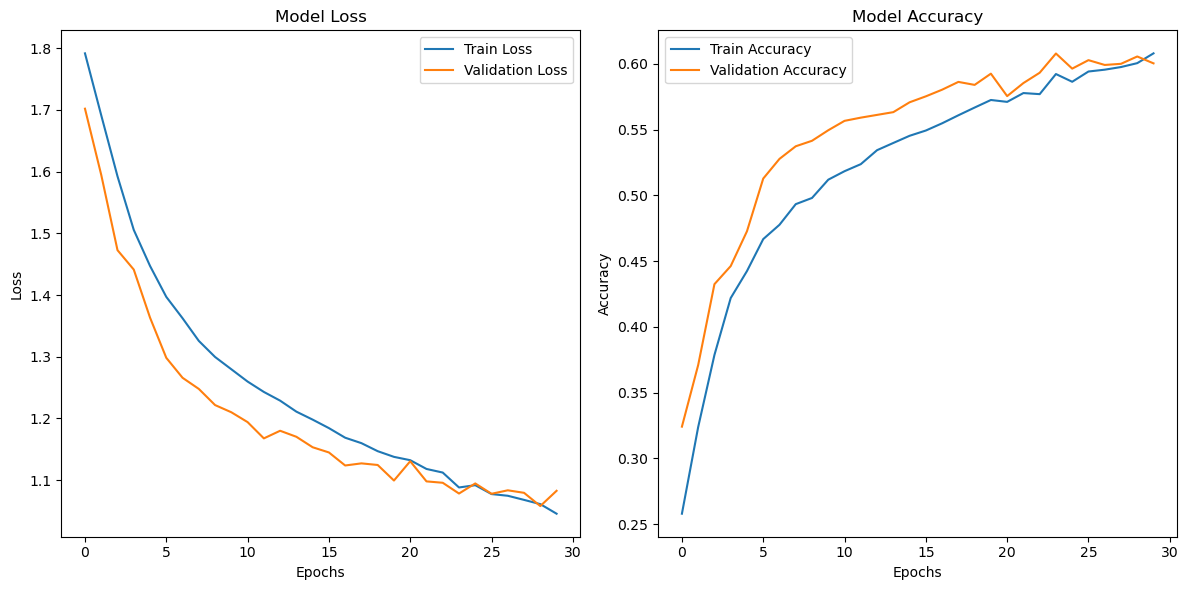

In [49]:
# 학습 시각화
# 손실 함수 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [69]:
# 예측 및 confusion matrix 계산
y_pred = cnn_model_gray.predict(test_ds_gray)
y_pred = np.argmax(y_pred, axis=1)
y_true = []
for _, labels in test_ds_gray:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # 원-핫 → 정수 인덱스
y_true = np.array(y_true)

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step


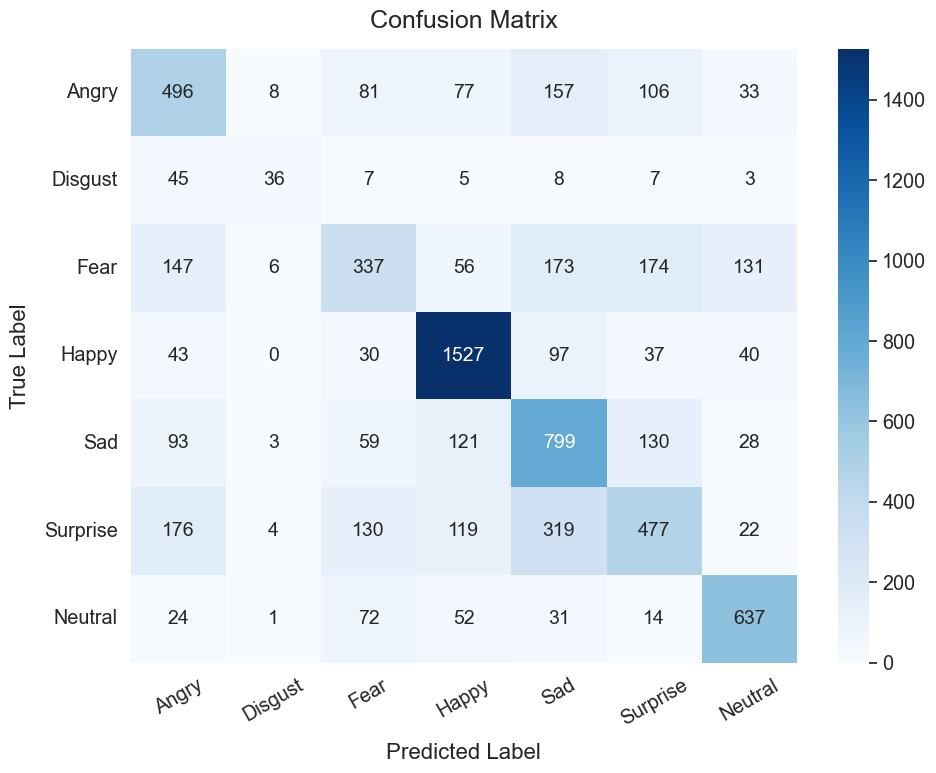

In [74]:
# Confusion matrix 계산
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.3)
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    cmap='Blues',
    cbar=True,
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 14}
)
ax.set_xlabel('Predicted Label', fontsize=16, labelpad=10)
ax.set_ylabel('True Label', fontsize=16, labelpad=10)
ax.set_title('Confusion Matrix', fontsize=18, pad=15)
plt.yticks(rotation=0)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [75]:
# 모든 클래스에 대해 TP, FP, FN, TN 및 Precision, Recall, F1-score 출력
for idx, name in enumerate(class_names):
    TP, FP, FN, TN = get_tp_fp_fn_tn(cm, idx)
    precision, recall, f1_score = calculate_metrics(TP, FP, FN)
    print(f"[{name}]")
    print(f"  TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
    print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}\n")

[Angry]
  TP: 496, FP: 528, FN: 462, TN: 5692
  Precision: 0.4844, Recall: 0.5177, F1-Score: 0.5005

[Disgust]
  TP: 36, FP: 22, FN: 75, TN: 7045
  Precision: 0.6207, Recall: 0.3243, F1-Score: 0.4260

[Fear]
  TP: 337, FP: 379, FN: 687, TN: 5775
  Precision: 0.4707, Recall: 0.3291, F1-Score: 0.3874

[Happy]
  TP: 1527, FP: 430, FN: 247, TN: 4974
  Precision: 0.7803, Recall: 0.8608, F1-Score: 0.8185

[Sad]
  TP: 799, FP: 785, FN: 434, TN: 5160
  Precision: 0.5044, Recall: 0.6480, F1-Score: 0.5673

[Surprise]
  TP: 477, FP: 468, FN: 770, TN: 5463
  Precision: 0.5048, Recall: 0.3825, F1-Score: 0.4352

[Neutral]
  TP: 637, FP: 257, FN: 194, TN: 6090
  Precision: 0.7125, Recall: 0.7665, F1-Score: 0.7386



In [ ]:
# 저장
with open('emotion_cnn_gray_history.json', 'w') as f:
    json.dump(history.history, f)

#### CNN Model 2 (Gray-scale)
> 3 Convolutional Layers + 2 FC Layers

> Learning Time: 96 Minutes

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomTranslation(0.1, 0.1),    # width_shift_range=0.1, height_shift_range=0.1
    layers.RandomZoom(0.1),                # zoom_range=0.1
    layers.RandomFlip("horizontal"),       # horizontal_flip=True
])

# CNN 모델
# 32, 64, 128, 512 필터를 사용한 모델
cnn_model_gray2 = Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 1)),  # Input Layer
    layers.Rescaling(1./255),
    data_augmentation,  # Data Augmentation Layer
    layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, kernel_size=(5, 5), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(7, activation='softmax')
])

# Compile the model
cnn_model_gray2.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

cnn_model_gray2.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)         │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,982,535 (11.38 MB)

 Trainable params: 2,980,295 (11.37 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

history = cnn_model_gray2.fit(train_ds_gray, epochs=50, validation_data=val_ds_gray, callbacks=[early_stopping]) 

Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 115s 309ms/step - accuracy: 0.1831 - loss: 4.5244 - val_accuracy: 0.2275 - val_loss: 4.2914
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 116s 324ms/step - accuracy: 0.2078 - loss: 3.9939 - val_accuracy: 0.2745 - val_loss: 3.7043
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 106s 294ms/step - accuracy: 0.2402 - loss: 3.6765 - val_accuracy: 0.3076 - val_loss: 3.2621
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 106s 295ms/step - accuracy: 0.2578 - loss: 3.3792 - val_accuracy: 0.3269 - val_loss: 3.0085
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 105s 292ms/step - accuracy: 0.2740 - loss: 3.0950 - val_accuracy: 0.3546 - val_loss: 2.6985
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 107s 299ms/step - accuracy: 0.2992 - loss: 2.8205 - val_accuracy: 0.3712 - val_loss: 2.4818
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 113s 315ms/step - accuracy: 0.3137 - loss: 2.5989 - val_accuracy: 0.3881 - val_loss: 2.3148
Epoch 8/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 108s 300ms/step - accuracy: 0.3447 -

In [ ]:
# 모델 평가
test_loss, test_accuracy = cnn_model_gray2.evaluate(test_ds_gray)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.5657 - loss: 1.2535
Test Loss: 1.1532005071640015
Test Accuracy: 0.6128448247909546


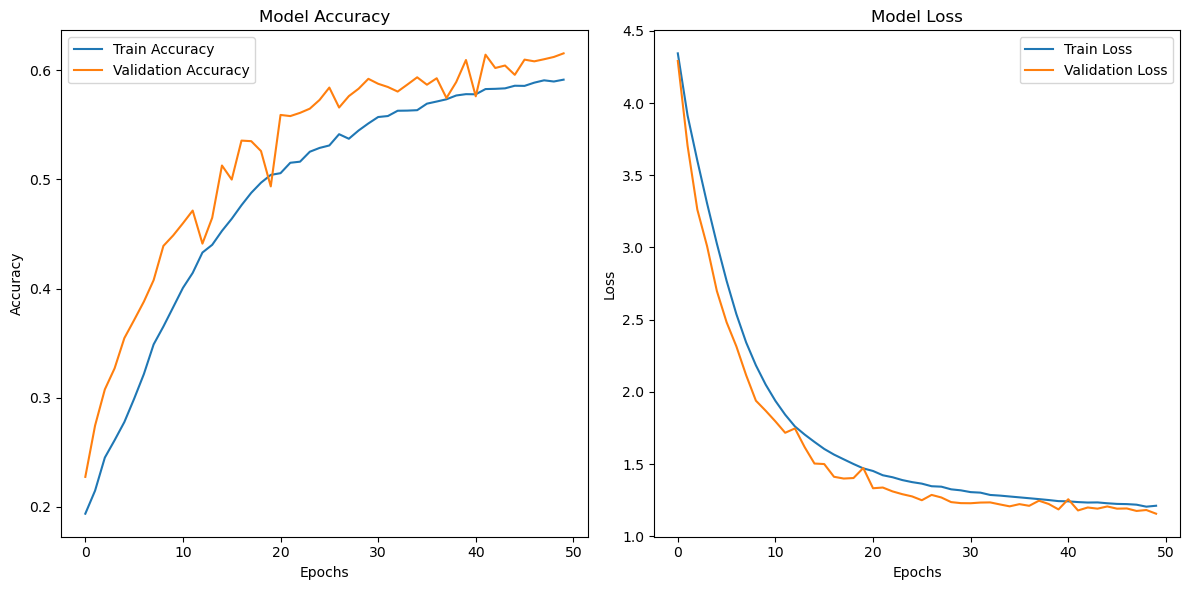

In [55]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 예측 및 confusion matrix 계산
y_pred = cnn_model_gray2.predict(test_ds_gray)
y_pred = np.argmax(y_pred, axis=1)
y_true = []
for _, labels in test_ds_gray:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # 원-핫 → 정수 인덱스
y_true = np.array(y_true)

113/113 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step


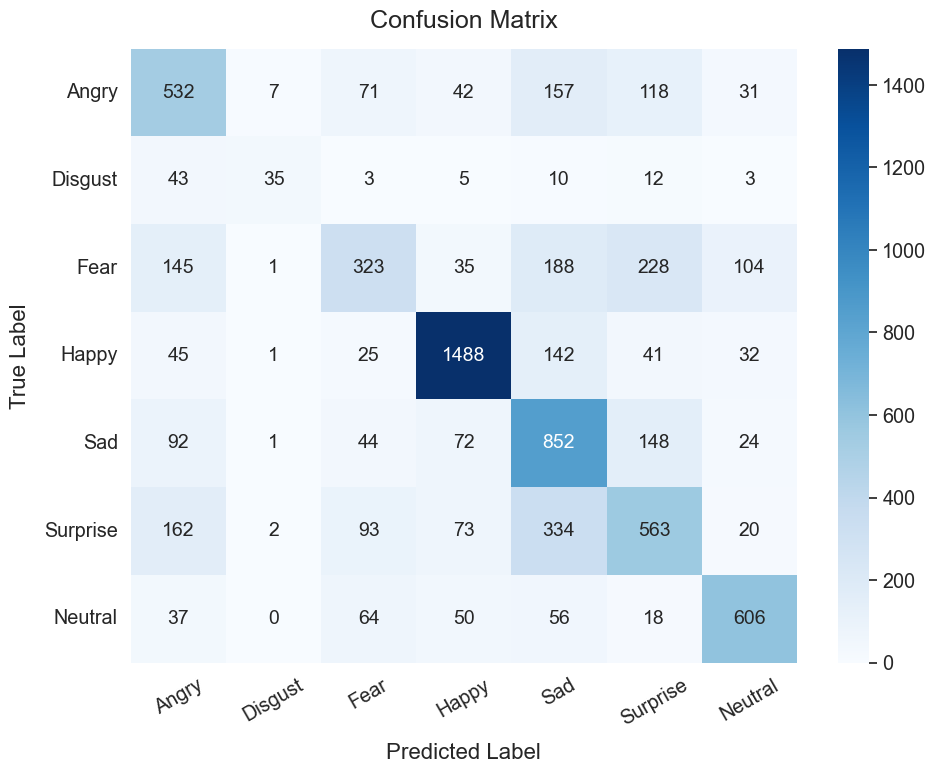

In [57]:
# Confusion matrix 계산
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.3)
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    cmap='Blues',
    cbar=True,
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 14}
)
ax.set_xlabel('Predicted Label', fontsize=16, labelpad=10)
ax.set_ylabel('True Label', fontsize=16, labelpad=10)
ax.set_title('Confusion Matrix', fontsize=18, pad=15)
plt.yticks(rotation=0)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [ ]:
# 모든 클래스에 대해 TP, FP, FN, TN 및 Precision, Recall, F1-score 출력
for idx, name in enumerate(class_names):
    TP, FP, FN, TN = get_tp_fp_fn_tn(cm, idx)
    precision, recall, f1_score = calculate_metrics(TP, FP, FN)
    print(f"[{name}]")
    print(f"  TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
    print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}\n")

[Angry]
  TP: 532, FP: 524, FN: 426, TN: 5696
  Precision: 0.5038, Recall: 0.5553, F1-Score: 0.5283

[Disgust]
  TP: 35, FP: 12, FN: 76, TN: 7055
  Precision: 0.7447, Recall: 0.3153, F1-Score: 0.4430

[Fear]
  TP: 323, FP: 300, FN: 701, TN: 5854
  Precision: 0.5185, Recall: 0.3154, F1-Score: 0.3922

[Happy]
  TP: 1488, FP: 277, FN: 286, TN: 5127
  Precision: 0.8431, Recall: 0.8388, F1-Score: 0.8409

[Sad]
  TP: 852, FP: 887, FN: 381, TN: 5058
  Precision: 0.4899, Recall: 0.6910, F1-Score: 0.5734

[Surprise]
  TP: 563, FP: 565, FN: 684, TN: 5366
  Precision: 0.4991, Recall: 0.4515, F1-Score: 0.4741

[Neutral]
  TP: 606, FP: 214, FN: 225, TN: 6133
  Precision: 0.7390, Recall: 0.7292, F1-Score: 0.7341



In [ ]:
# 모델 저장
cnn_model_gray2.save('emotion_cnn_2_gray.h5')

# History 저장
with open('emotion_cnn_2_gray_history.json', 'w') as f:
    json.dump(history.history, f)

#### Stacked CNN Model (Gray-scale)

> 4 Stacked Convolutional Layers + FC Layer

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomRotation(0.0417),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom(0.1),
    layers.RandomFlip("horizontal"),
])

stacked_cnn_model = Sequential([
    layers.Input(shape=(64, 64, 1)),  # Grayscale, 64x64

    data_augmentation,

    # Stacked Conv Block 1
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Stacked Conv Block 2
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Stacked Conv Block 3
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    # Stacked Conv Block 4
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')
])

stacked_cnn_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

stacked_cnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,048,83

 Total params: 2,225,255 (8.49 MB)

 Trainable params: 2,223,783 (8.48 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [24]:
# 모델 학습
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

history = stacked_cnn_model.fit(train_ds_gray, epochs=50, validation_data=val_ds_gray, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 111s 309ms/step - accuracy: 0.1805 - loss: 2.8738 - val_accuracy: 0.1675 - val_loss: 2.5319 - learning_rate: 1.0000e-04
Epoch 2/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 110s 306ms/step - accuracy: 0.2123 - loss: 2.3826 - val_accuracy: 0.2333 - val_loss: 2.2948 - learning_rate: 1.0000e-04
Epoch 3/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 112s 311ms/step - accuracy: 0.2243 - loss: 2.2563 - val_accuracy: 0.2958 - val_loss: 1.7895 - learning_rate: 1.0000e-04
Epoch 4/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 109s 303ms/step - accuracy: 0.2430 - loss: 2.1381 - val_accuracy: 0.3090 - val_loss: 1.8088 - learning_rate: 1.0000e-04
Epoch 5/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 113s 315ms/step - accuracy: 0.2610 - loss: 2.0666 - val_accuracy: 0.2946 - val_loss: 1.9203 - learning_rate: 1.0000e-04
Epoch 6/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 111s 308ms/step - accuracy: 0.2896 - loss: 1.9595 - val_accuracy: 0.3444 - val_loss: 1.6892 - learning_rate: 1.0000e-04
Epoch 7/50
359/359 ━━━━━━━━━━━━━━━━━━━━ 

In [25]:
# 모델 평가
test_loss, test_accuracy = stacked_cnn_model.evaluate(test_ds_gray)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.6008 - loss: 1.0726
Test Loss: 0.9803449511528015
Test Accuracy: 0.6334633827209473


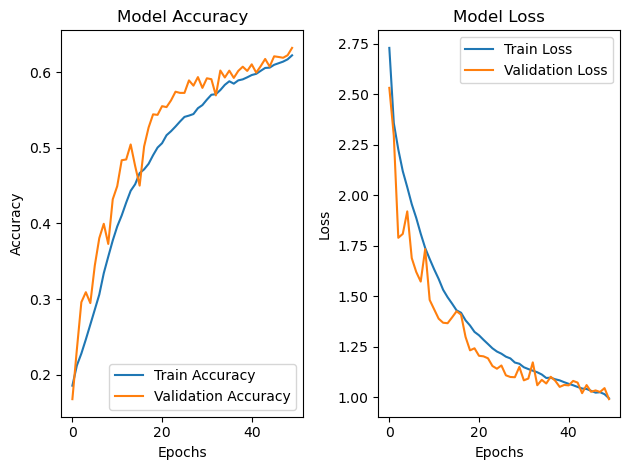

In [26]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [27]:
# 모델 저장
stacked_cnn_model.save('emotion_cnn_gray_stacked.h5')

In [28]:
# 예측 및 confusion matrix 계산
y_pred = stacked_cnn_model.predict(test_ds_gray)
y_pred = np.argmax(y_pred, axis=1)
y_true = []
for _, labels in test_ds_gray:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # 원-핫 → 정수 인덱스
y_true = np.array(y_true)

113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step


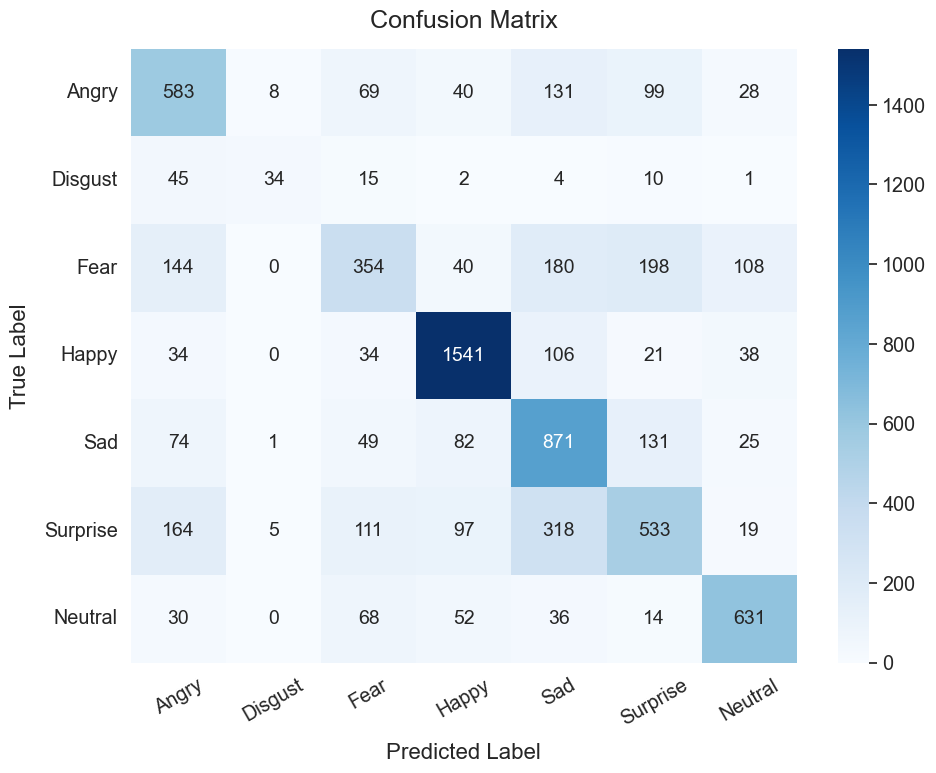

In [29]:
# Confusion matrix 계산
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.3)
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    cmap='Blues',
    cbar=True,
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 14}
)
ax.set_xlabel('Predicted Label', fontsize=16, labelpad=10)
ax.set_ylabel('True Label', fontsize=16, labelpad=10)
ax.set_title('Confusion Matrix', fontsize=18, pad=15)
plt.yticks(rotation=0)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [ ]:
# 모든 클래스에 대해 TP, FP, FN, TN 및 Precision, Recall, F1-score 출력
for idx, name in enumerate(class_names):
    TP, FP, FN, TN = get_tp_fp_fn_tn(cm, idx)
    precision, recall, f1_score = calculate_metrics(TP, FP, FN)
    print(f"[{name}]")
    print(f"  TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
    print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}\n")

[Angry]
  TP: 583, FP: 491, FN: 375, TN: 5729
  Precision: 0.5428, Recall: 0.6086, F1-Score: 0.5738

[Disgust]
  TP: 34, FP: 14, FN: 77, TN: 7053
  Precision: 0.7083, Recall: 0.3063, F1-Score: 0.4277

[Fear]
  TP: 354, FP: 346, FN: 670, TN: 5808
  Precision: 0.5057, Recall: 0.3457, F1-Score: 0.4107

[Happy]
  TP: 1541, FP: 313, FN: 233, TN: 5091
  Precision: 0.8312, Recall: 0.8687, F1-Score: 0.8495

[Sad]
  TP: 871, FP: 775, FN: 362, TN: 5170
  Precision: 0.5292, Recall: 0.7064, F1-Score: 0.6051

[Surprise]
  TP: 533, FP: 473, FN: 714, TN: 5458
  Precision: 0.5298, Recall: 0.4274, F1-Score: 0.4731

[Neutral]
  TP: 631, FP: 219, FN: 200, TN: 6128
  Precision: 0.7424, Recall: 0.7593, F1-Score: 0.7507



### Data Adjustment

#### Data Loading

In [ ]:
batch_size = 64
img_size = (64, 64)  # 이미지 크기 (너비, 높이)

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  #color_mode='grayscale',
  #validation_split=0.2,
  labels='inferred',
  label_mode='categorical',
  #subset="training",
  seed=42,
  image_size=(img_size[0], img_size[1]),
  batch_size=batch_size,
  shuffle = True)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    #color_mode='grayscale',
    #validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    #subset="validation",
    seed=42,
    image_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    shuffle=False # 검증 데이터는 일반적으로 셔플링하지 않음
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    #color_mode='grayscale',
    labels='inferred',
    label_mode='categorical',
    image_size=(img_size[0], img_size[1]),
    batch_size=batch_size,
    shuffle=False, # 테스트 데이터는 일반적으로 셔플링하지 않음
    seed=42      # 재현성을 위해 seed 설정 (데이터 순서에 영향 없음)
)

Found 22965 files belonging to 7 classes.
Found 5744 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [34]:
# 이미지 구조
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)  # batch, height, width, RGB channel
  print(labels_batch.shape)    # batch
  break

for image_batch, labels_batch in val_ds:
  print(image_batch.shape)  # batch, height, width, RGB channel
  print(labels_batch.shape)    # batch
  break

for image_batch, labels_batch in test_ds:
  print(image_batch.shape)  # batch, height, width, RGB channel
  print(labels_batch.shape)    # batch
  break

(64, 224, 224, 3)
(64, 7)
(64, 224, 224, 3)
(64, 7)
(64, 224, 224, 3)
(64, 7)


In [35]:
# 데이터 병목 완화
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

#### EfficientNet

In [25]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(img_size[0], img_size[1], 3)
)
base_model.trainable = False # 기본 모델의 가중치를 고정

model_efficientnet = tf.keras.Sequential([
    keras.Input(shape=(img_size[0], img_size[1], 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [26]:
# 최적화 알고리즘, 손실 함수 설정, 평가 지표
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
model_efficientnet.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_efficientnet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 2, 2, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,372,586 (20.49 MB)

 Trainable params: 1,320,967 (5.04 MB)

 Non-trainable params: 4,051,619 (15.46 MB)

In [27]:
# 모델 학습
history = model_efficientnet.fit(train_ds, epochs=30, validation_data=val_ds, 
                        callbacks=[early_stopping, reduce_lr])

Epoch 1/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 120ms/step - accuracy: 0.1731 - loss: 2.1014 - val_accuracy: 0.1106 - val_loss: 1.9832 - learning_rate: 1.0000e-04
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 49s 136ms/step - accuracy: 0.2113 - loss: 1.9543 - val_accuracy: 0.1729 - val_loss: 2.1612 - learning_rate: 1.0000e-04
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 40s 111ms/step - accuracy: 0.2074 - loss: 1.9383 - val_accuracy: 0.1682 - val_loss: 2.4236 - learning_rate: 1.0000e-04
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 43s 119ms/step - accuracy: 0.2123 - loss: 1.9147 - val_accuracy: 0.1729 - val_loss: 2.8747 - learning_rate: 1.0000e-04
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 138ms/step - accuracy: 0.2185 - loss: 1.8979 - val_accuracy: 0.1106 - val_loss: 2.1779 - learning_rate: 1.0000e-04
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 50s 140ms/step - accuracy: 0.2200 - loss: 1.8921 - val_accuracy: 0.2512 - val_loss: 1.9100 - learning_rate: 1.0000e-04
Epoch 7/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 45s 12

In [60]:
# 모델 평가
test_loss, test_accuracy = model_efficientnet.evaluate(test_ds)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.2208 - loss: 1.8717
Test Loss: 1.8004776239395142
Test Accuracy: 0.25146281719207764


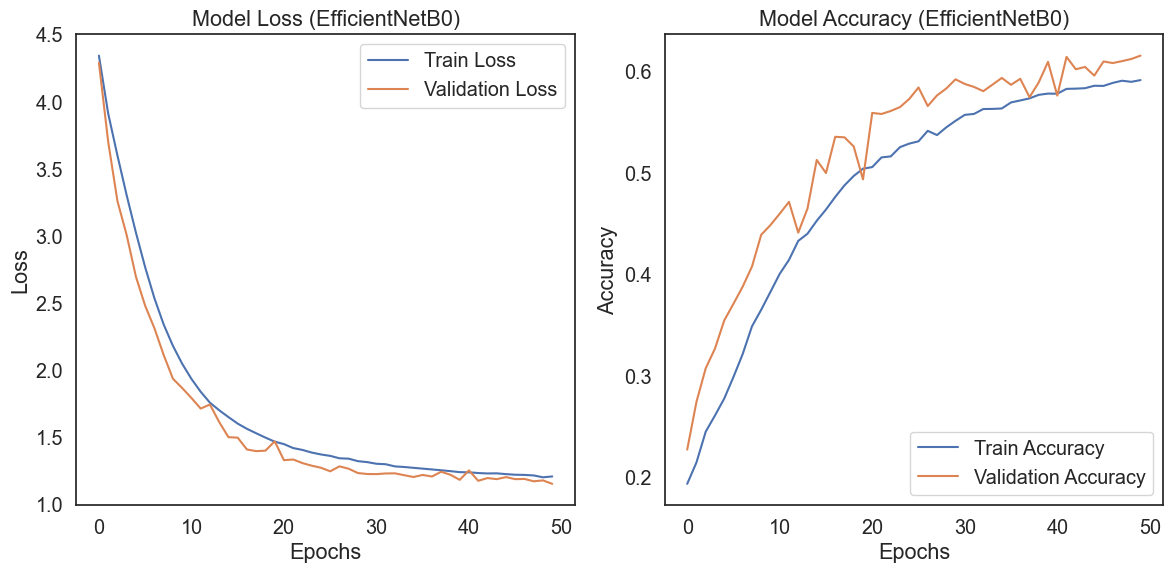

In [65]:
# 손실 및 정확도 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (EfficientNetB0)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy (EfficientNetB0)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [62]:
# 예측 및 confusion matrix 계산
y_pred = model_efficientnet.predict(test_ds_gray)
y_pred = np.argmax(y_pred, axis=1)
y_true = []
for _, labels in test_ds_gray:
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # 원-핫 → 정수 인덱스
y_true = np.array(y_true)

113/113 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step


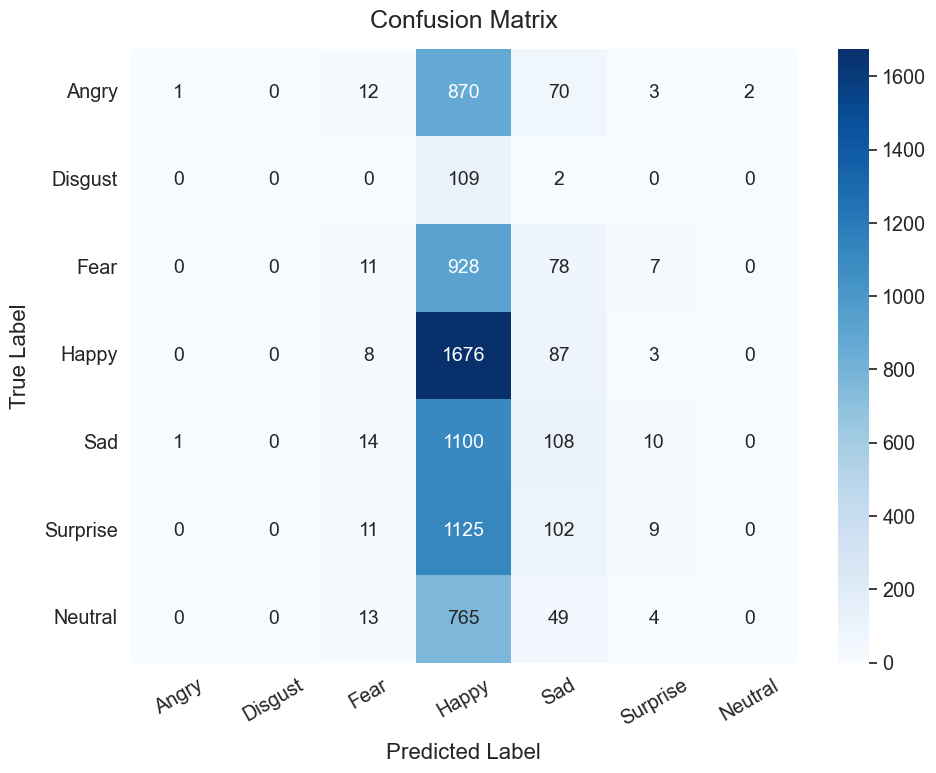

In [63]:
# Confusion matrix 계산
cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plt.figure(figsize=(10, 8))
sns.set(style="white", font_scale=1.3)
ax = sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    cmap='Blues',
    cbar=True,
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 14}
)
ax.set_xlabel('Predicted Label', fontsize=16, labelpad=10)
ax.set_ylabel('True Label', fontsize=16, labelpad=10)
ax.set_title('Confusion Matrix', fontsize=18, pad=15)
plt.yticks(rotation=0)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [64]:
# 모든 클래스에 대해 TP, FP, FN, TN 및 Precision, Recall, F1-score 출력
for idx, name in enumerate(class_names):
    TP, FP, FN, TN = get_tp_fp_fn_tn(cm, idx)
    precision, recall, f1_score = calculate_metrics(TP, FP, FN)
    print(f"[{name}]")
    print(f"  TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
    print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}\n")

[Angry]
  TP: 1, FP: 1, FN: 957, TN: 6219
  Precision: 0.5000, Recall: 0.0010, F1-Score: 0.0021

[Disgust]
  TP: 0, FP: 0, FN: 111, TN: 7067
  Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000

[Fear]
  TP: 11, FP: 58, FN: 1013, TN: 6096
  Precision: 0.1594, Recall: 0.0107, F1-Score: 0.0201

[Happy]
  TP: 1676, FP: 4897, FN: 98, TN: 507
  Precision: 0.2550, Recall: 0.9448, F1-Score: 0.4016

[Sad]
  TP: 108, FP: 388, FN: 1125, TN: 5557
  Precision: 0.2177, Recall: 0.0876, F1-Score: 0.1249

[Surprise]
  TP: 9, FP: 27, FN: 1238, TN: 5904
  Precision: 0.2500, Recall: 0.0072, F1-Score: 0.0140

[Neutral]
  TP: 0, FP: 2, FN: 831, TN: 6345
  Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000



In [ ]:
# 모델 저장
model_efficientnet.save('emotion_efficientnet.h5')  

In [ ]:
# 저장
with open('efficientnet_history.json', 'w') as f:
    json.dump(history.history, f)